# This is the main notebook for Speech Emotion Recognition
This notebook is dependent on the preprocessing done by the creating_labels.ipynb and create_MFCC_dictionary.ipynb notebooks. I create the model and observe its performance in this notebook. 

The text : """A Jupyter widget could not be displayed because the widget state could not be found. This could happen if the kernel storing the widget is no longer available, or if the widget state was not saved in the notebook. You may be able to create the widget by running the appropriate cells."""

,is the result of the notebook not storing the progress bars created by tqdm library. Please ignore it.

## Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import os
import IPython.display as ipd
from tqdm import tqdm_notebook
import seaborn as sn
import torch
import torch.nn as nn
import random as rn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch.optim as optim

SEED = 2222 
np.random.seed(SEED)
rn.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Setting up GPU
Checking if the system has GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Checking the space being used on the GPU.

In [3]:
if(str(device) == 'cuda'): print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

0.0M


## Loading the dataset

In [4]:
data_directory = 'D:/Kaggle/datasets/Audio_Speech_Actors_01-24/RAVDESS/'

In [5]:
data = pd.read_csv(data_directory + 'dataset.csv',encoding ='utf-8')

Creating the training and validation dataset.

In [6]:
train , val = train_test_split(data, test_size=0.25, shuffle=True, random_state=SEED)
train = train.reset_index(drop = True)
val = val.reset_index(drop = True)
len(train),len(val)

(720, 240)

In [7]:
train.head()

,fname,male_angry,male_happy,male_calm,male_fearful,male_sad,female_angry,female_happy,female_calm,female_fearful,female_sad
0,03-01-04-01-01-02-19.wav,0,0,0,0,1,0,0,0,0,0
1,03-01-03-02-01-01-11.wav,0,1,0,0,0,0,0,0,0,0
2,03-01-06-01-02-01-07.wav,0,0,0,1,0,0,0,0,0,0
3,03-01-04-01-01-01-02.wav,0,0,0,0,0,0,0,0,0,1
4,03-01-06-02-02-01-06.wav,0,0,0,0,0,0,0,0,1,0


## Loading the .npy files
These are the various files with MFCCs of each audio file stored in them. Each file has different MFCCs based on the data augmentations performed on them. 

In [8]:
mfcc_dictionary = np.load(data_directory + 'RAVDESS_mfcc_100_259.npy',allow_pickle=True)
mfcc_speedNpitch_dictionary = np.load(data_directory + 'RAVDESS_speedNpitch_100_259.npy',allow_pickle=True)
mfcc_noise_dictionary = np.load(data_directory + 'RAVDESS_noise_100_259.npy',allow_pickle=True)
mfcc_shift_dictionary = np.load(data_directory + 'RAVDESS_shift_100_259.npy',allow_pickle=True)
mfcc_noise_and_shift_dictionary = np.load(data_directory + 'RAVDESS_noise_and_shift_100_259.npy',allow_pickle=True)

## Extracting the data from .npy files
The below cell extracts MFCCs without any augmentaions. I also calculate the mean of the extracted MFCCs to use them as additional features for my model.

In [9]:
sample_rate = 44100
dim = (100,1 + int(np.floor((sample_rate * 3)/512)))
X_train = np.empty(shape=(len(train), dim[0], dim[1]))
X_train_1d = np.empty(shape=(len(train), dim[1]))

for i in tqdm_notebook(range(len(train))):
    X_train[i,] = mfcc_dictionary[()][str(train['fname'][i])]
    X_train_1d[i,] = np.mean(mfcc_dictionary[()][str(train['fname'][i])],axis = 0)

The below cell extracts MFCCs with Speed and Pitch augmentaions. I also calculate the mean of the extracted MFCCs to use them as additional features for my model.

In [10]:
X_train_speedNpitch = np.empty(shape=(len(train), dim[0], dim[1]))
X_train_1d_speedNpitch = np.empty(shape=(len(train), dim[1]))
for i in tqdm_notebook(range(len(train))):
    X_train_speedNpitch[i,] = mfcc_speedNpitch_dictionary[()][str(train['fname'][i])]
    X_train_1d_speedNpitch[i,] = np.mean(mfcc_speedNpitch_dictionary[()][str(train['fname'][i])],axis = 0)

The below cell extracts MFCCs with noise augmentaion. I also calculate the mean of the extracted MFCCs to use them as additional features for my model.

In [11]:
X_train_noise = np.empty(shape=(len(train), dim[0], dim[1]))
X_train_1d_noise = np.empty(shape=(len(train), dim[1]))
for i in tqdm_notebook(range(len(train))):
    X_train_noise[i,] = mfcc_noise_dictionary[()][str(train['fname'][i])]
    X_train_1d_noise[i,] = np.mean(mfcc_noise_dictionary[()][str(train['fname'][i])],axis = 0)

The below cell extracts MFCCs with shifting augmentaion. I also calculate the mean of the extracted MFCCs to use them as additional features for my model.

In [12]:
X_train_shift = np.empty(shape=(len(train), dim[0], dim[1]))
X_train_1d_shift = np.empty(shape=(len(train), dim[1]))
for i in tqdm_notebook(range(len(train))):
    X_train_shift[i,] = mfcc_shift_dictionary[()][str(train['fname'][i])]
    X_train_1d_shift[i,] = np.mean(mfcc_shift_dictionary[()][str(train['fname'][i])],axis = 0)

The below cell extracts MFCCs with noise and shifting augmentaion. I also calculate the mean of the extracted MFCCs to use them as additional features for my model.

In [13]:
X_train_noise_and_shift = np.empty(shape=(len(train), dim[0], dim[1]))
X_train_1d_train_noise_and_shift = np.empty(shape=(len(train), dim[1]))
for i in tqdm_notebook(range(len(train))):
    X_train_noise_and_shift[i,] = mfcc_noise_and_shift_dictionary[()][str(train['fname'][i])]
    X_train_1d_train_noise_and_shift[i,] = np.mean(mfcc_noise_and_shift_dictionary[()][str(train['fname'][i])],axis = 0)

The below cell extracts MFCCs without any augmentaion as I don't want to increase the complexity of validation set with data augmentations. I also calculate the mean of the extracted MFCCs to use them as additional features for my model.

In [14]:
sample_rate = 44100
dim = (100,1 + int(np.floor((sample_rate * 3)/512)))
X_val = np.empty(shape=(len(val), dim[0], dim[1]))
X_val_1d = np.empty(shape=(len(val), dim[1]))
for i in tqdm_notebook(range(len(val))):
    X_val[i,] = mfcc_dictionary[()][str(val['fname'][i])]
    X_val_1d[i,] = np.mean(mfcc_dictionary[()][str(val['fname'][i])],axis = 0)

Deleting the mfcc dictionaries as they won't be needed any more.

In [15]:
del mfcc_dictionary 
del mfcc_speedNpitch_dictionary
del mfcc_noise_dictionary
del mfcc_shift_dictionary 
del mfcc_noise_and_shift_dictionary 

## Creating the training dataset
The MfCCs collected from the different .npy files is concatenated to form a proper dataset. Here, I also concatenate the means of the respective MFCCs to form another dataset.

In [16]:
X_train = np.concatenate((X_train,X_train_noise_and_shift,X_train_speedNpitch,X_train_noise,X_train_shift), axis=0)
X_train_1d = np.concatenate((X_train_1d,X_train_1d_train_noise_and_shift,X_train_1d_speedNpitch,X_train_1d_noise,X_train_1d_shift), axis=0)

Normalizing the dataset has shown to improve performance of the model. The cell below normalizes the MFCC values.

In [17]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_val = (X_val - mean)/std

 The cell below normalizes the means of the MFCC values.

In [18]:
mean_1d = np.mean(X_train_1d, axis=0)
std_1d = np.std(X_train_1d, axis=0)

X_train_1d = (X_train_1d - mean_1d)/std_1d
X_val_1d = (X_val_1d - mean_1d)/std_1d

Extracting the labels from the dataframe. The labels are of multi-hot encoded format.

In [19]:
y_train = train.iloc[:,1:]
y_val = val.iloc[:,1:]

In [20]:
y_train = y_train.values.tolist()
y_val = y_val.values.tolist()

The y_train is multiplied by 5 to adjust the size of the labels for the increase in the size of X_train after concatenation. Since I am not shuffling the X_train dataset and simply concatenating it, the labels perfectly align after being multiplied. Since I am not changing the size of X_val, there is no need to multiply y_val with any factor.

In [21]:
y_train = y_train*5
y_val = y_val

## Creating Dataloaders
The data is now shifted into tensors and is then fed into a dataloader. I have used torch.utils.data.DataLoader for this task.

In [22]:
BATCH_SIZE = 60

In [23]:
X_train_tensor = torch.tensor(X_train)
X_val_tensor = torch.tensor(X_val)

In [24]:
X_train_tensor_1d = torch.tensor(X_train_1d)
X_val_tensor_1d = torch.tensor(X_val_1d)

In [25]:
y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)

In [26]:
train_dataset = TensorDataset(X_train_tensor,X_train_tensor_1d,y_train_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

In [27]:
val_dataset = TensorDataset(X_val_tensor,X_val_tensor_1d,y_val_tensor)
val_sampler = RandomSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=BATCH_SIZE)

## Defining model
I decided to go with a CNN based architecture. I have made two Convolution Blocks, one for MFCC values and one for the means of the MFCC values.

In [28]:
class Convblock(nn.Module):  #for MFCC values
    def __init__(self,in_dim,out_dim,kernel,stride = 1,pool = (2,2)):
        super().__init__()
        self.conv = nn.Conv2d(in_dim,out_dim,kernel, stride=stride, padding=0)
        self.batchnorm = nn.BatchNorm2d(out_dim)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(pool)
        self.avgpool = nn.AvgPool2d(pool)
       
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        #x = self.maxpool(x)
        x = self.avgpool(x)
        return x
        

In [29]:
class Convblock1D(nn.Module): #for means of MFCC values
    def __init__(self,in_dim,out_dim,kernel,stride = 1,pool = 2):
        super().__init__()
        self.conv = nn.Conv1d(in_dim,out_dim,kernel, stride=stride, padding=0)
        self.batchnorm = nn.BatchNorm1d(out_dim)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(pool)
        self.avgpool = nn.AvgPool1d(pool)
       
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        #x = self.maxpool(x)
        x = self.avgpool(x)
        return x

Through trial and error, I arrived at this configuration for my main model.

In [30]:
class Net(nn.Module):  #main model
    def __init__(self,num_labels,convblock = Convblock,convblock1d = Convblock1D):
        super().__init__()
        self.convolution = nn.Sequential(convblock(1,16,(3,5)),nn.Dropout(0.2),convblock(16,16,(3,5)),nn.Dropout(0.2),convblock(16,16,(3,5)),nn.Dropout(0.2),convblock(16,16,(3,5)),nn.Dropout(0.2))
        self.convolution1d = nn.Sequential(convblock1d(1,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2),convblock1d(16,16,5),nn.Dropout(0.2))
        self.dense = nn.Sequential(nn.Linear(16*4*12 + 16*12,64),nn.BatchNorm1d(64),nn.ReLU(),nn.Linear(64,num_labels))
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x,y):
        x = self.convolution(x)
        #print(x.shape)
        x = x.view(x.shape[0],-1)
        
        y = self.convolution1d(y)
        #print(y.shape)
        y = y.view(y.shape[0],-1)
        
        z = torch.cat((x,y),dim = 1)
        z = self.dense(z)
        z = self.sigmoid(z)
        return z

## Defining training parameters
Shifting the model to GPU if the system has the ability.

In [31]:
model = Net(num_labels = 10).to(device)

Checking the space being used on the GPU.

In [32]:
if(str(device) == 'cuda'): print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

0.339456M


I have used Adam optimizer as in my experiance it works well with nn.BCELoss().

In [33]:
optimizer = optim.Adam(model.parameters(),lr=0.001)

I tried to use a variable learning rate using torch.optim.lr_scheduler.StepLR but I was unable to properly configure it for my task, hence decided to abandon it.

In [34]:
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

I chose nn.BCELoss() as it works well with multi-hot encoded labels.

In [35]:
criterion = nn.BCELoss().to(device)

Defining accuracy metrics.

In [36]:
def f1_Accuracy(y_pred,y_true):
    
    y_pred_0 = y_pred.cpu()
    y_true_0 = y_true.cpu()
    return f1_score(y_true_0 , y_pred_0 > 0.5, average='weighted')

In [37]:
def Accuracy(y_pred,y_true):
    y_true = y_true.cpu().detach().numpy().tolist()
    y_pred = y_pred.cpu().detach().numpy().tolist()
    ambiguious = 0
    correct = 0
    for i in range(len(y_pred)):
        try:
            pred_index = list(map(lambda x: 0 if x <0.5 else 1,y_pred[i])).index(1)
            true_index = y_true[i].index(1)
            if(pred_index == true_index):
                correct = correct + 1
        except:
             ambiguious = ambiguious + 1
    return correct/len(y_pred)

## Training
I have created several empty lists and dictionaries to store the progress of model's accuracy and loss characteristics. This is done to make it easy for us to observe the characteristic graphs and figure out the best configuration for our model.

In [38]:
train_losses = []
eval_losses = []
train_acc = []
val_acc = []
train_f1_acc = []
val_f1_acc = []
history_train_y_true = {}
history_train_y_pred = {}
history_val_y_true = {}
history_val_y_pred = {}

In [39]:
EPOCHS = 50

In [40]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0 #to calculate the epoch loss
    y_train_true = torch.Tensor().to(device)  #I use these tensors to calculate the epoch accuracy 
    y_train_pred = torch.Tensor().to(device)
    tqdm_dataloader = tqdm_notebook(enumerate(train_dataloader),total =(len(X_train) / BATCH_SIZE) ) #to monitor progress of the code
    for step_num,batch in tqdm_dataloader:
        audio_data,audio_data_1d,labels = tuple(t.to(device) for t in batch) #extracting batch data
        audio_data = audio_data.unsqueeze(1).float()   #using unsqueeze to match the input dimensions to those needed by the model
        audio_data_1d = audio_data_1d.unsqueeze(1).float()   #using unsqueeze to match the input dimensions to those needed by the model
        labels = labels.float()
        optimizer.zero_grad()
        logits = model(audio_data,audio_data_1d)
        y_train_true = torch.cat((y_train_true,labels), 0)  #storing batch labels
        y_train_pred = torch.cat((y_train_pred,logits), 0)  #storing batch preds
        batch_loss  = criterion(logits,labels)
        train_loss += batch_loss.item()
        tqdm_dataloader.set_description("Epoch {} train : {} {} ".format(epoch + 1,"loss:" , str(round(train_loss / (step_num + 1) , 4))))
        batch_loss.backward()
        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step() 

    #recording loss and accuracy
    train_losses.append(train_loss/(step_num + 1))
    train_acc.append(Accuracy(y_train_pred,y_train_true))
    train_f1_acc.append(f1_Accuracy(y_train_pred,y_train_true))
    history_train_y_true[epoch] = y_train_true
    history_train_y_pred[epoch] = y_train_pred
    
    model.eval()
    eval_loss = 0        #to calculate the epoch loss
    y_val_true = torch.Tensor().to(device)   #I use these tensors to calculate the epoch accuracy 
    y_val_pred = torch.Tensor().to(device)
    tqdm_dataloader = tqdm_notebook(enumerate(val_dataloader),total =(len(X_val) / BATCH_SIZE) )  #to monitor progress of the code
    with torch.no_grad():
        for step_num,batch in tqdm_dataloader:
            audio_data,audio_data_1d,labels = tuple(t.to(device) for t in batch)  #extracting batch data
            audio_data = audio_data.unsqueeze(1).float()   #using unsqueeze to match the input dimensions to those needed by the model
            audio_data_1d = audio_data_1d.unsqueeze(1).float() #using unsqueeze to match the input dimensions to those needed by the model
            labels = labels.float()
            logits = model(audio_data,audio_data_1d)
            y_val_true = torch.cat((y_val_true,labels), 0)  #storing batch labels
            y_val_pred = torch.cat((y_val_pred,logits), 0)  #storing batch preds
            batch_loss  = criterion(logits,labels)
            eval_loss += batch_loss.item()
            tqdm_dataloader.set_description("Epoch {} val : {} {} ".format(epoch + 1,"loss:" , str(round(eval_loss / (step_num + 1) , 4))))
    
    #recording loss and accuracy
    eval_losses.append(eval_loss/(step_num + 1))
    val_acc.append(Accuracy(y_val_pred,y_val_true))  
    val_f1_acc.append(f1_Accuracy(y_val_pred,y_val_true))
    history_val_y_true[epoch] = y_val_true
    history_val_y_pred[epoch] = y_val_pred
    #scheduler.step() #(not used in this code)

D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Observations

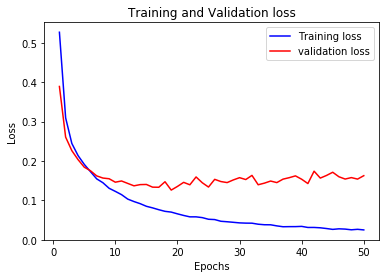

In [41]:
epochs = range(1, EPOCHS + 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, eval_losses, 'r', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

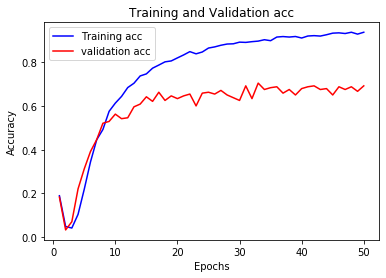

In [42]:
epochs = range(1, EPOCHS + 1 )
plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

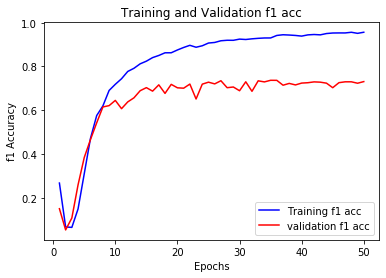

In [43]:
epochs = range(1, EPOCHS + 1 )
plt.plot(epochs, train_f1_acc, 'b', label='Training f1 acc')
plt.plot(epochs, val_f1_acc, 'r', label='validation f1 acc')
plt.title('Training and Validation f1 acc')
plt.xlabel('Epochs')
plt.ylabel('f1 Accuracy')
plt.legend()
plt.show()

In [44]:
max(train_acc)*100

93.66666666666667

In [45]:
max(val_acc)*100

70.41666666666667

In [46]:
max(val_f1_acc)*100

73.67064587201116

Checking the epoch at which the accuracies are maximum,i.e- before overfitting becomes a problem.

In [47]:
val_acc.index(max(val_acc)) , val_f1_acc.index(max(val_f1_acc))

(32, 34)

In [48]:
idx = val_f1_acc.index(max(val_f1_acc))

In [49]:
def confusion_matrix_val(idx):
    y_true = history_val_y_true[idx] 
    y_pred = history_val_y_pred[idx] 
    matrix = np.zeros((y_true.shape[1],y_true.shape[1]))
    y_true = y_true.cpu().detach().numpy().tolist()
    y_pred = y_pred.cpu().detach().numpy().tolist()
    ambiguious = 0
    for i in range(len(y_pred)):
        try:
            pred_index = list(map(lambda x: 0 if x <0.5 else 1,y_pred[i])).index(1)
            true_index = y_true[i].index(1)
            matrix[true_index][pred_index] = matrix[true_index][pred_index] + 1
        except:
             ambiguious = ambiguious + 1
    df_cm = pd.DataFrame(matrix, index = [i for i in ['male_angry','male_happy','male_calm','male_fearful','male_sad','female_angry','female_happy','female_calm','female_fearful','female_sad']],columns = [i for i in ['male_angry','male_happy','male_calm','male_fearful','male_sad','female_angry','female_happy','female_calm','female_fearful','female_sad']])
    plt.figure(figsize = (11,7))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap="Blues",annot=True)
    return ambiguious

In [50]:
def confusion_matrix_train(idx):
    y_true = history_train_y_true[idx] 
    y_pred = history_train_y_pred[idx] 
    matrix = np.zeros((y_true.shape[1],y_true.shape[1]))
    y_true = y_true.cpu().detach().numpy().tolist()
    y_pred = y_pred.cpu().detach().numpy().tolist()
    ambiguious = 0
    for i in range(len(y_pred)):
        try:
            pred_index = list(map(lambda x: 0 if x <0.5 else 1,y_pred[i])).index(1)
            true_index = y_true[i].index(1)
            matrix[true_index][pred_index] = matrix[true_index][pred_index] + 1
        except:
             ambiguious = ambiguious + 1
    df_cm = pd.DataFrame(matrix, index = [i for i in ['male_angry','male_happy','male_calm','male_fearful','male_sad','female_angry','female_happy','female_calm','female_fearful','female_sad']],columns = [i for i in ['male_angry','male_happy','male_calm','male_fearful','male_sad','female_angry','female_happy','female_calm','female_fearful','female_sad']])
    plt.figure(figsize = (11,7))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap="Blues",annot=True)
    return ambiguious

Plotting the confusion matrix with the maximum f1 accuracy.

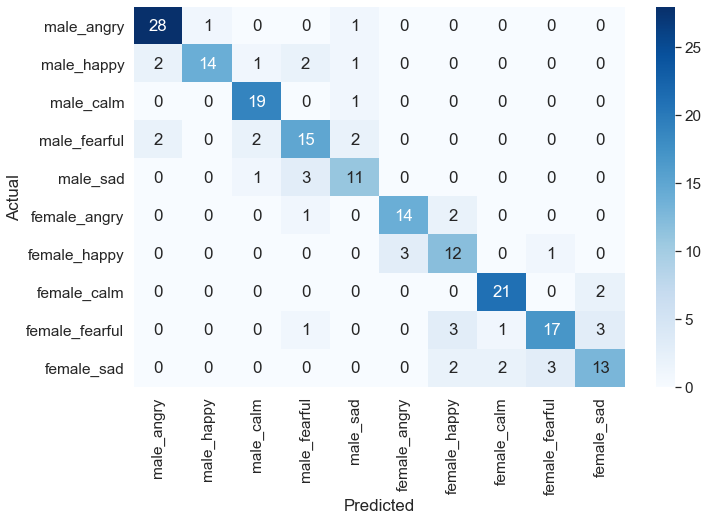

In [51]:
ambiguious_val = confusion_matrix_val(idx)

ambiguious_val are the number of instances in validation set for which the model was unable to assign any class to the inputs. This number should be as small as possible for a good model.

In [52]:
ambiguious_val

33

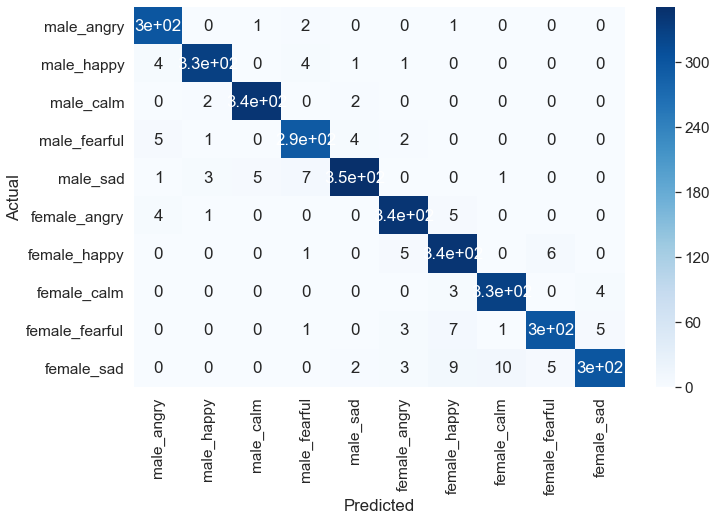

In [53]:
ambiguious_train = confusion_matrix_train(idx)

ambiguious_train are the number of instances in training set for which the model was unable to assign any class to the inputs. This number should be as small as possible for a good model.

In [54]:
ambiguious_train

245